In [27]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download historical data for SPY and VIX
spy_data = yf.download("SPY", start="2020-01-01", end="2024-01-01", interval="1d")
vix_data = yf.download("^VIX", start="2020-01-01", end="2024-01-01", interval="1d")

# Merge SPY and VIX data
data = pd.merge(spy_data, vix_data, on='Date', suffixes=('_SPY', '_VIX'))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
data.head(5)

Price,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,,,,,,
2020-01-02,301.194855,301.213415,299.025387,299.961792,59151200,12.47,13.720000,12.42,13.46,0
2020-01-03,298.914215,300.054588,297.699684,297.755309,77709700,14.02,16.200001,13.13,15.01,0
2020-01-06,300.054535,300.137973,297.013540,297.134071,55653900,13.85,16.389999,13.54,15.45,0
2020-01-07,299.210876,299.961845,298.756566,299.479722,40496400,13.79,14.460000,13.39,13.84,0
2020-01-08,300.805573,302.038636,299.155292,299.405605,68296000,13.45,15.240000,12.83,15.16,0


In [29]:
data.shape

(1006, 10)

In [30]:
# Renaming columns to High_SPY, High_VIX, etc.
data.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in data.columns]
data.reset_index(drop=True, inplace=True)

In [31]:
data.head(5)

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Close_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX
0,301.194855,301.213415,299.025387,299.961792,59151200,12.47,13.720000,12.42,13.46,0
1,298.914215,300.054588,297.699684,297.755309,77709700,14.02,16.200001,13.13,15.01,0
2,300.054535,300.137973,297.013540,297.134071,55653900,13.85,16.389999,13.54,15.45,0
3,299.210876,299.961845,298.756566,299.479722,40496400,13.79,14.460000,13.39,13.84,0
4,300.805573,302.038636,299.155292,299.405605,68296000,13.45,15.240000,12.83,15.16,0


In [32]:
# Calculate daily returns and price range for SPY
data['Returns_SPY'] = data['Close_SPY'].pct_change()
data['Range_SPY'] = data['High_SPY'] - data['Low_SPY']

# Define target variable: 1 if SPY price remains within a range, 0 otherwise
range_threshold = data['Range_SPY'].quantile(0.25)  # Use the 25th percentile as a threshold
data['Target'] = np.where(data['Range_SPY'] < range_threshold, 1, 0)

# Drop missing values
data.dropna(inplace=True)

In [42]:
data['Range_SPY'].quantile(0.25)

2.9690711230668967

In [44]:
data['Target'].value_counts()

Target
0    754
1    251
Name: count, dtype: int64

In [10]:
import talib

# Calculate technical indicators for SPY
data['SMA_SPY'] = talib.SMA(data['Close_SPY'], timeperiod=20)
data['RSI_SPY'] = talib.RSI(data['Close_SPY'], timeperiod=14)
data['ATR_SPY'] = talib.ATR(data['High_SPY'], data['Low_SPY'], data['Close_SPY'], timeperiod=14)
data['IV_SPY'] = data['Close_SPY'].rolling(window=14).std()  # Historical volatility

# Use VIX as a feature
data['VIX'] = data['Close_^VIX']

# Drop rows with missing values (due to indicator calculations)
data.dropna(inplace=True)

# Define features and target
features = ['SMA_SPY', 'RSI_SPY', 'ATR_SPY', 'IV_SPY', 'VIX']
X = data[features]
y = data['Target']

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for LSTM (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data into training and testing sets
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

c:\Users\Deepika Sagar\Documents\OptionsTrading\ot\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7228 - loss: 0.6834 - val_accuracy: 0.6701 - val_loss: 0.6681
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7894 - loss: 0.6284 - val_accuracy: 0.6701 - val_loss: 0.6384
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8042 - loss: 0.5274 - val_accuracy: 0.6701 - val_loss: 0.6803
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7873 - loss: 0.4867 - val_accuracy: 0.6701 - val_loss: 0.6866
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8048 - loss: 0.4566 - val_accuracy: 0.6701 - val_loss: 0.6657
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7968 - loss: 0.4538 - val_accuracy: 0.6701 - val_loss: 0.6505
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7823 - loss: 0.4420 - val_accuracy: 0.6701 - val_loss: 0.6387
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7807 - loss: 0.4347 - val_accuracy: 0.6701 - val_loss

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


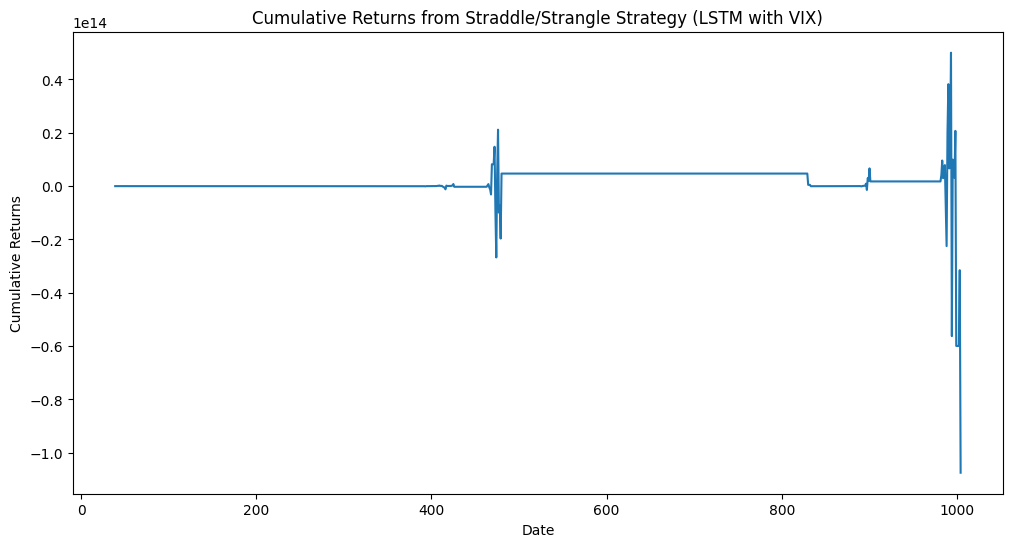

In [12]:
# Generate predictions for the entire dataset
data['Prediction'] = model.predict(X_reshaped).flatten()

# Define trading logic: Sell straddle/strangle if prediction is 1 (low volatility)
data['Signal'] = np.where(data['Prediction'] > 0.5, 'sell_straddle', 'hold')

# Simulate trades
data['Trade_Returns'] = np.where(data['Signal'].shift(1) == 'sell_straddle', 
                                 data['Range_SPY'].shift(-1) - data['Range_SPY'], 0)

# Calculate cumulative returns
data['Cumulative_Returns'] = (1 + data['Trade_Returns']).cumprod()

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Returns'])
plt.title("Cumulative Returns from Straddle/Strangle Strategy (LSTM with VIX)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.show()

In [18]:
import gym
from gym import spaces
import numpy as np

class OptionsTradingEnv(gym.Env):
    def __init__(self, data):
        super(OptionsTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.max_steps = len(data) - 1

        # Define action space: 0 = hold, 1 = sell straddle
        self.action_space = spaces.Discrete(2)

        # Define observation space: SMA_SPY, RSI_SPY, ATR_SPY, IV_SPY, VIX
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step][['SMA_SPY', 'RSI_SPY', 'ATR_SPY', 'IV_SPY', 'VIX']].values

    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps:
            return None, 0, True, {}

        # Get current state
        state = self.data.iloc[self.current_step][['SMA_SPY', 'RSI_SPY', 'ATR_SPY', 'IV_SPY', 'VIX']].values

        # Calculate reward
        reward = 0
        if action == 1:  # Sell straddle
            reward = self.data.iloc[self.current_step]['Range_SPY'] - self.data.iloc[self.current_step - 1]['Range_SPY']

        # Check if episode is done
        done = self.current_step >= self.max_steps

        return state, reward, done, {}

# Create environment
env = OptionsTradingEnv(data)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

# Example: Create a vectorized environment
env = make_vec_env("CartPole-v1", n_envs=4, vec_env_cls=DummyVecEnv)

# Initialize the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Save model
model.save("options_trading_ppo_spy_vix")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 21.6     |
| time/              |          |
|    fps             | 4957     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 34.2        |
|    ep_rew_mean          | 34.2        |
| time/                   |             |
|    fps                  | 2046        |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014661399 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | -0.00167    |
|    learning

In [21]:
def trading_bot():
    while True:
        # Fetch real-time data
        data = fetch_real_time_data()

        # Predict using LSTM
        features = scaler.transform(data[['SMA_SPY', 'RSI_SPY', 'ATR_SPY', 'IV_SPY', 'VIX']])
        prediction = model.predict(features.reshape(1, 1, -1)).flatten()[0]

        # Decide action using RL agent
        action, _ = model.predict(features)

        # Execute trade
        if action == 1:  # Sell straddle
            place_straddle_order()

        time.sleep(60)  # Wait 1 minute before next iteration